In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, integrate, special
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings
import networkx as nx

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

In [3]:
# df_pre_lockdown = df[(df["started_at"] < "2020-03-21")].dropna()
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_2020_nov = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-12-01")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [5]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N

In [6]:
df_lockdown.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [7]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        start_station_name = df_tmp["start_station_name"].unique()

        # 各駅について、IDを割り振る
        station_id = {}
        for i, station in enumerate(start_station_name):
            station_id[station] = i
        
        # station_idを元に、df_lockdown_relax_2020_11にstation_idを追加
        df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)

        # ノードの数を取得
        node_list.append(len(station_id))

        # エッジの数を取得
        edge_list.append(len(df_tmp))
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list

In [8]:
node, edge = return_nm(df_2020_nov)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_42783/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_42783/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_42783/1207947706.py:27: SettingWithCopyWarning: 
A value is

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_42783/2291635319.py:4: RuntimeWarning: overflow encountered in scalar power
  return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)


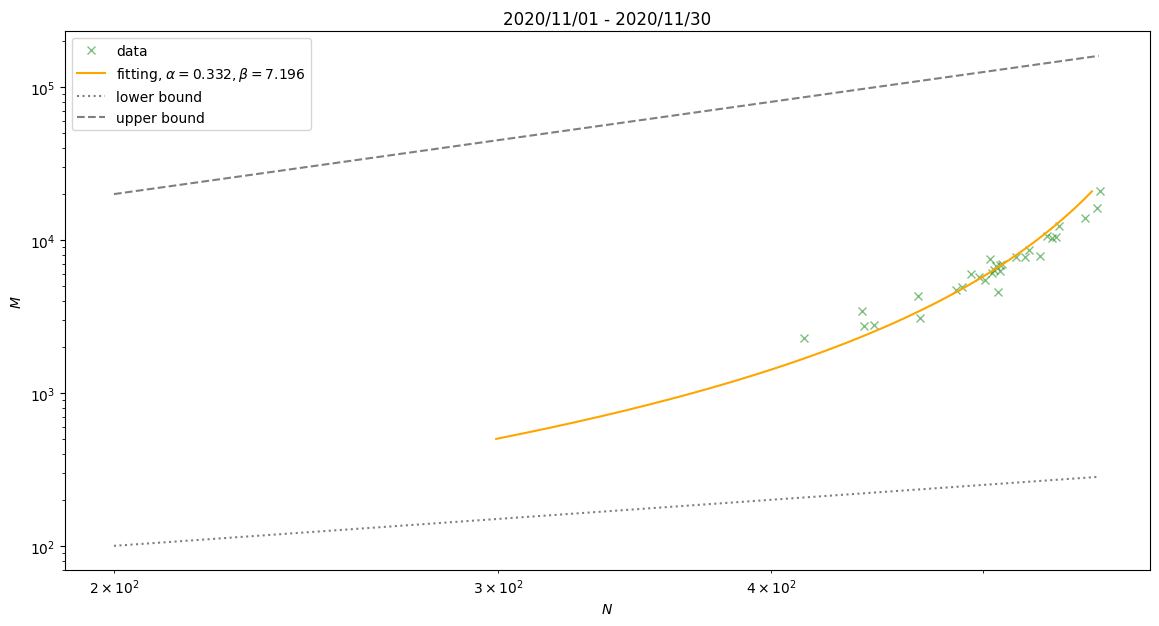

In [12]:
plt.figure(figsize=(14,7))

N = node
M = edge
Np = 677 # histrical dataから求めたNp

x = np.arange(200, np.max(N))
y = np.arange(500, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/11/01 - 2020/11/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [11]:
node

[489,
 510,
 538,
 540,
 535,
 557,
 566,
 564,
 542,
 523,
 504,
 518,
 509,
 494,
 446,
 505,
 498,
 506,
 531,
 525,
 507,
 467,
 501,
 414,
 441,
 468,
 508,
 509,
 486,
 440]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

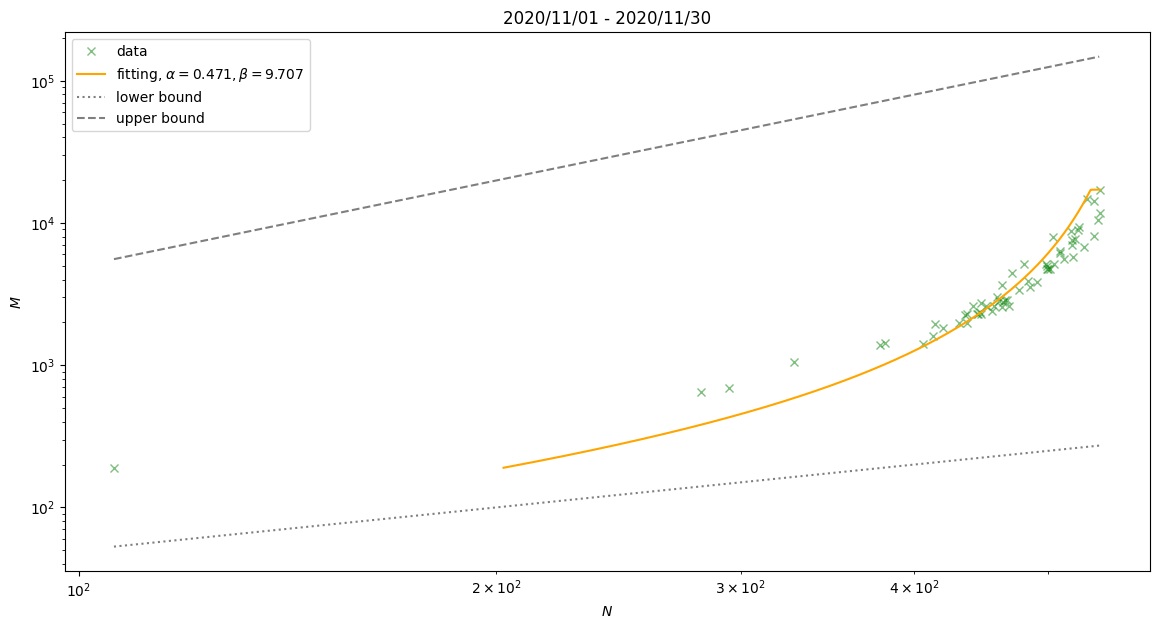

In [40]:
node, edge = return_nm(df_lockdown)

plt.figure(figsize=(14,7))

N = node
M = edge
Np = 596 # histrical dataから求めたNp

x = np.arange(np.min(N), np.max(N))
y = np.arange(np.min(M), np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/11/01 - 2020/11/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [13]:
node_lockdown, edge_lockdown = return_nm(df_lockdown)
node_resi1, edge_resi1 = return_nm(df_resi1)
node_resi2, edge_resi2 = return_nm(df_resi2)
node_2020_nov, edge_2020_nov = return_nm(df_2020_nov)
node_lockdown_relax, edge_lockdown_relax = return_nm(df_lockdown_relax)
node_after_lockdown, edge_after_lockdown = return_nm(df_after_lockdown)
node_aft_eto, edge_aft_eto = return_nm(df_aft_eto)


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

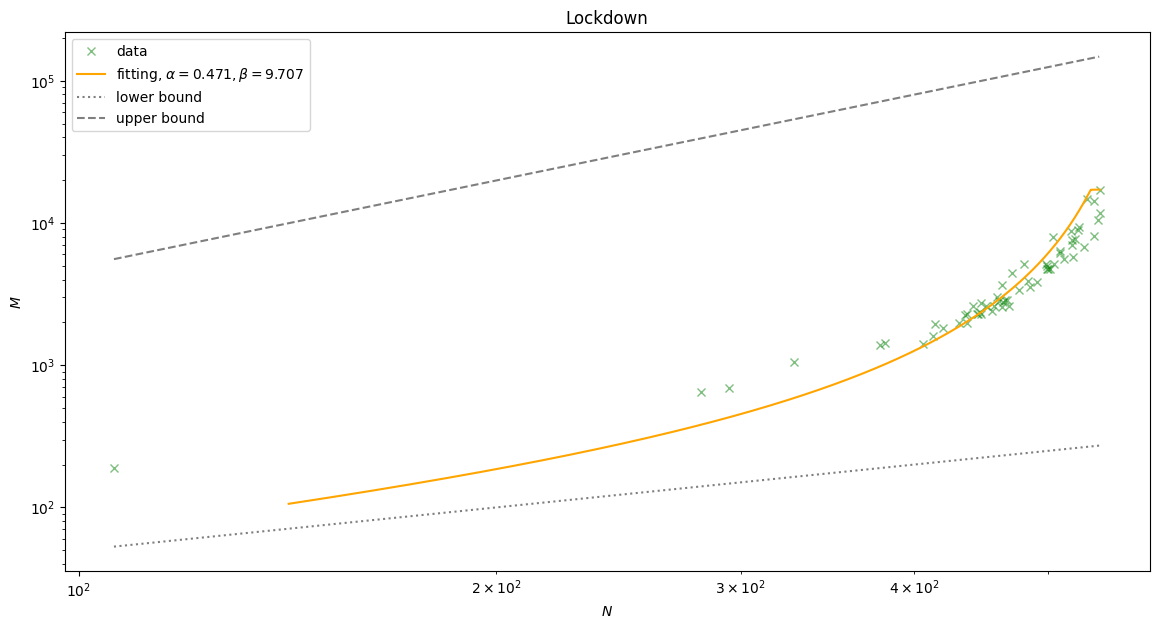

In [42]:
# lockdown
plt.figure(figsize=(14,7))

N = node_lockdown
M = edge_lockdown
Np = 596 # histrical dataから求めたNp

x = np.arange(np.min(N), np.max(N))
y = np.arange(np.min(N), np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:4: RuntimeWarning: overflow encountered in scalar power
  return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)


KeyboardInterrupt: 

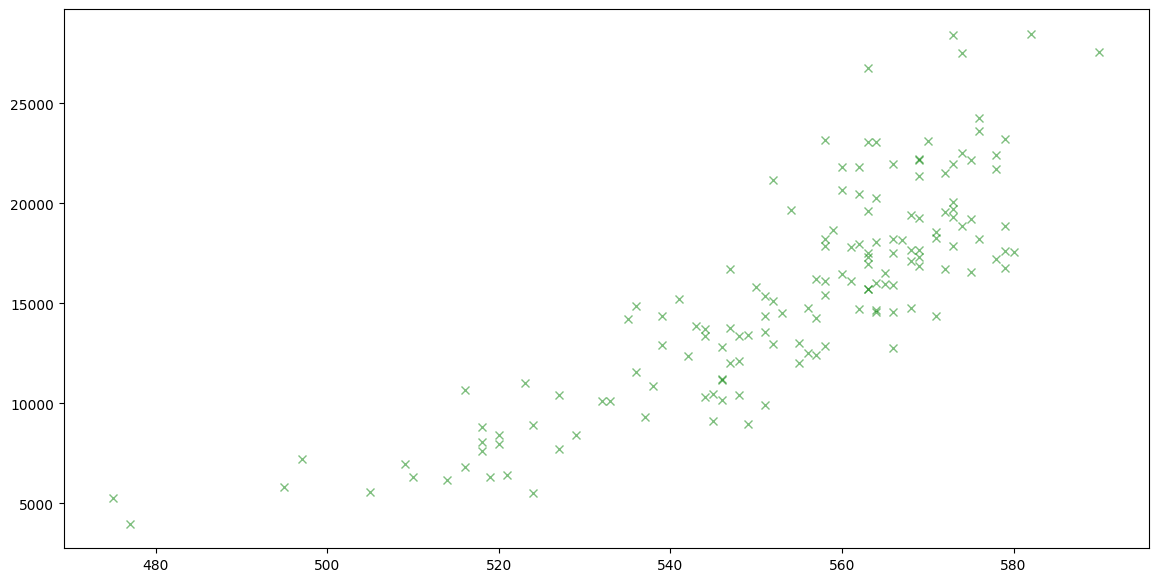

In [43]:
# Resilience1
plt.figure(figsize=(14,7))

N = node_resi1
M = edge_resi1
Np = 673 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.5, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/6/1~2020/10/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [23]:
df_2020_dec = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()
node_2020_dec, edge_2020_dec = return_nm(df_2020_dec)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


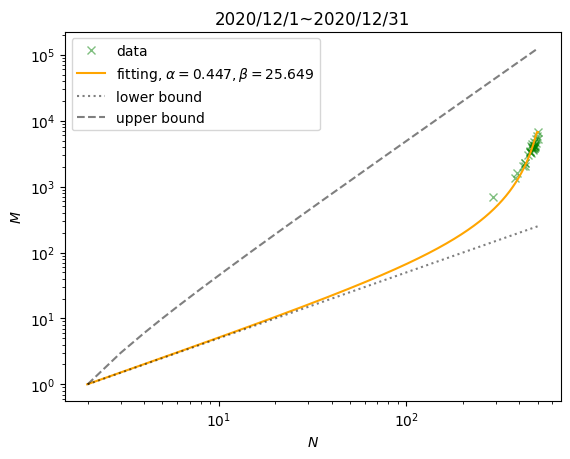

In [24]:
# lockdown
plt.Figure(figsize=(14,7))

N = node_2020_dec
M = edge_2020_dec
Np = 596 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/12/1~2020/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [25]:
# 2021/1/1~2021/12/31
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
node_2021, edge_2021 = return_nm(df_2021)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:4: RuntimeWarning: overflow encountered in scalar power
  return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yie

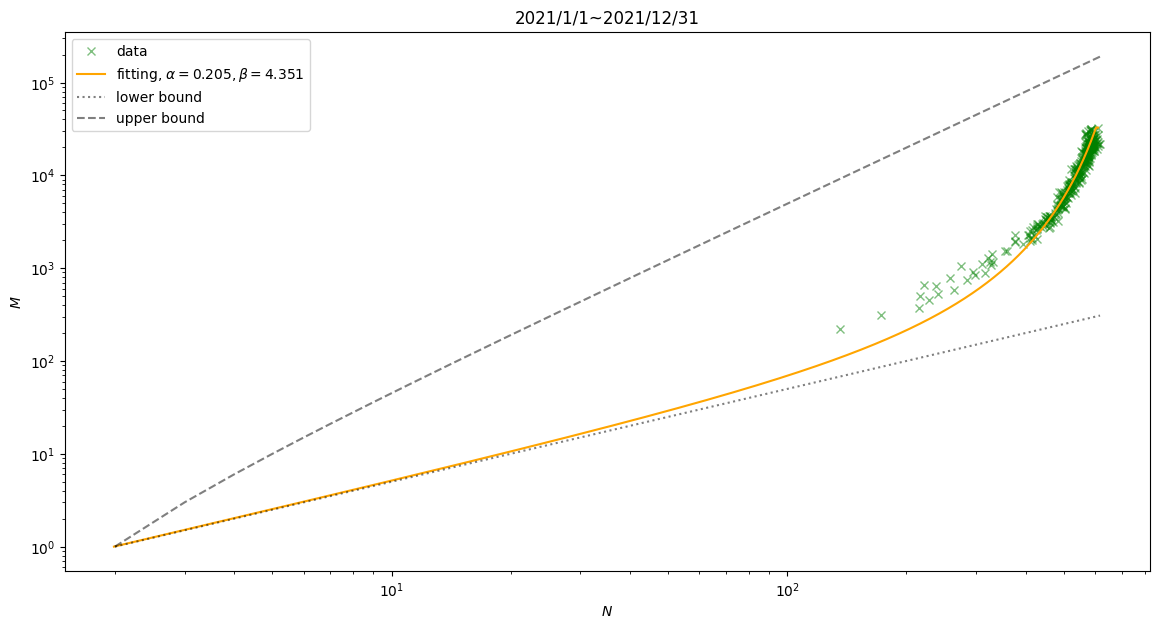

In [37]:
# lockdown
plt.figure(figsize=(14,7))

N = node_2021
M = edge_2021
Np = 846 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2021/1/1~2021/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [27]:
# 2022/1/1~2022/12/31
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
node_2022, edge_2022 = return_nm(df_2022)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  p

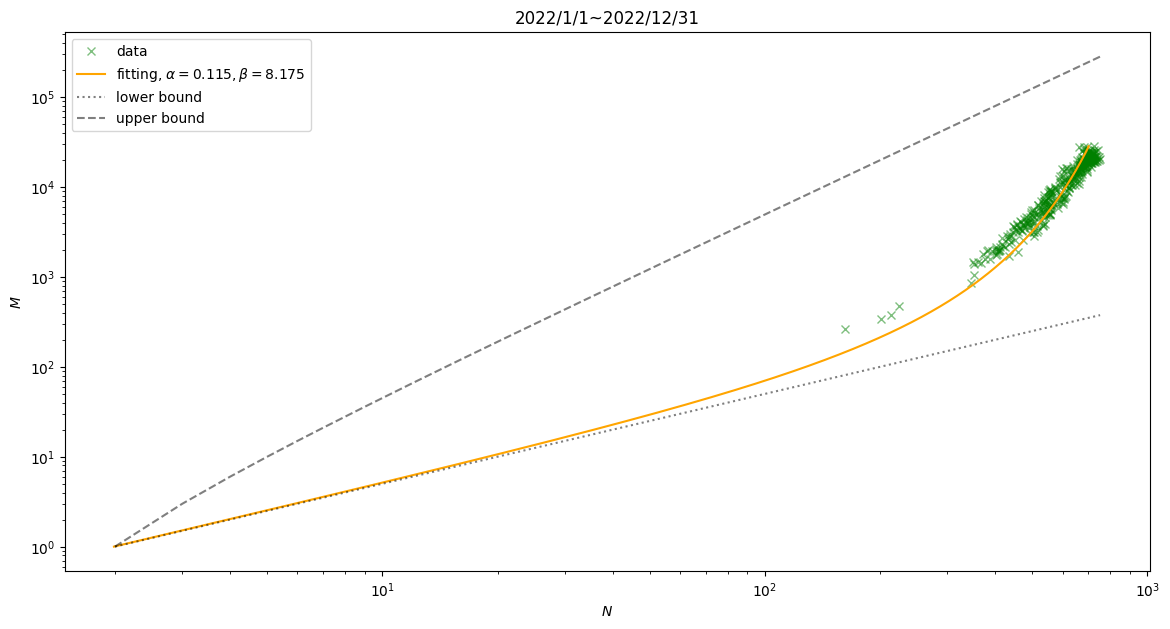

In [32]:
plt.figure(figsize=(14,7))

N = node_2022
M = edge_2022
Np = 1419 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2022/1/1~2022/12/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [29]:
# 2023/1/1~2023/12/31
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2024-01-01")].dropna()
node_2023, edge_2023 = return_nm(df_2023)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/1207947706.py:27: SettingWithCopyWarning: 
A value is

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:3: RuntimeWarning: overflow encountered in scalar power
  f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit 

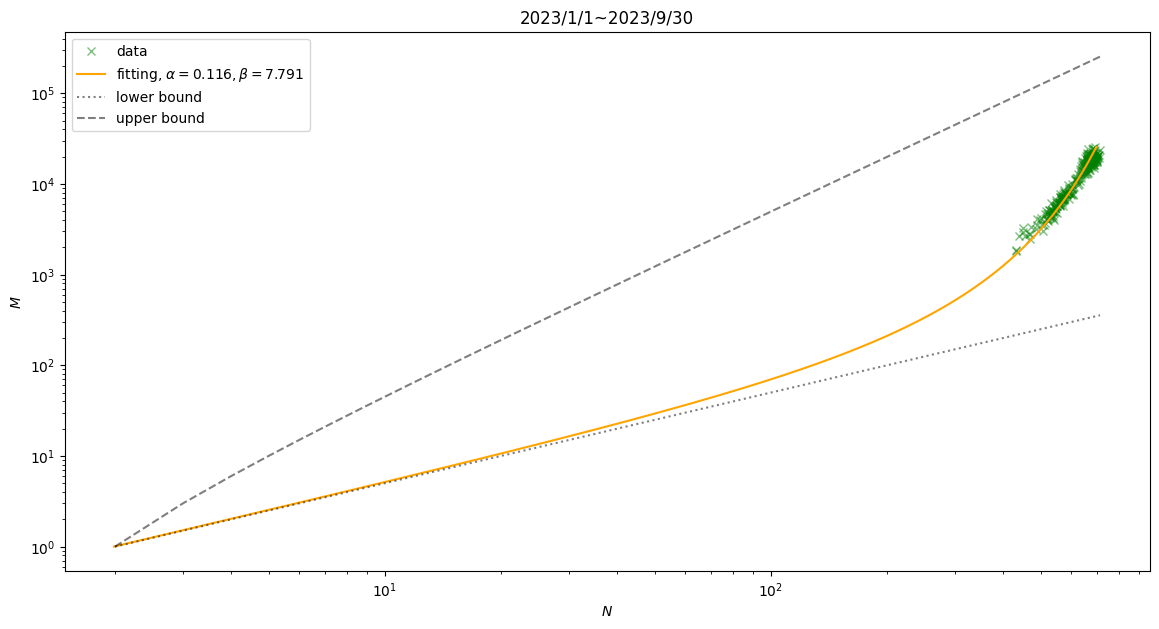

In [31]:
plt.figure(figsize=(14,7))

N = node_2023
M = edge_2023
Np = 1419 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")
plt.title("2023/1/1~2023/9/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

In [33]:
# 活動量のリストを作成
alpha_list = [0.471, 0.352, 0.471, 0.447, 0.205, 0.115, 0.116]
beta_list = [9.707, 5.342, 9.707, 25.649, 4.351, 8.175, 7.791]

label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_26837/240062979.py:8: RuntimeWarning: divide by zero encountered in power
  return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)


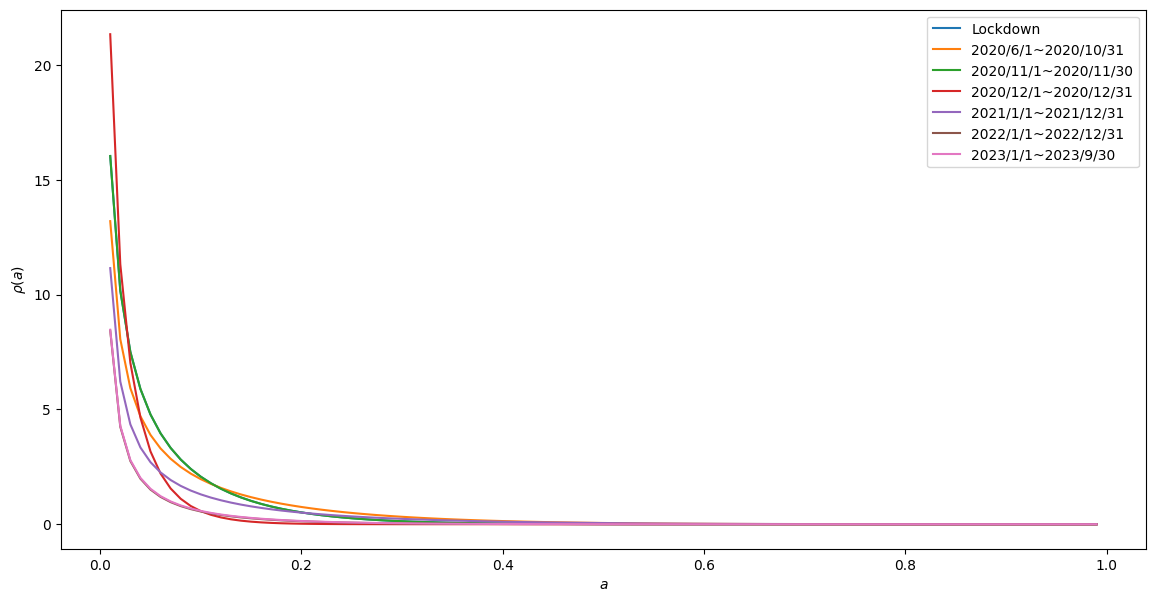

In [35]:
# 0から1まで0.01刻みでaを生成
a = np.arange(0, 1, 0.01)
plt.figure(figsize=(14,7))
for i in range(len(alpha_list)):
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=label_list[i])

plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
#plt.title(r"$\alpha^{*}=$"+str(round(alpha, 3))+r", $\beta^{*}=$"+str(round(beta, 3)))
plt.legend()
plt.show()